# Lab 1: Podstawowe metody analizy i przetwarzania obrazów

In [13]:
# ============================================
# Import potrzebnych bibliotek
# ============================================
import numpy as np                          # NumPy – obsługa tablic i obliczeń numerycznych
import matplotlib.pyplot as plt              # Matplotlib – do rysowania i wyświetlania obrazów
from skimage import io, color, exposure, filters, util, morphology, data, transform
# skimage.io          – wczytywanie/zapisywanie obrazów
# skimage.color       – konwersja przestrzeni barw (np. RGB → grayscale)
# skimage.exposure    – regulacja jasności, kontrastu, histogramów itp.
# skimage.filters     – filtry obrazu (np. rozmycie, wykrywanie krawędzi)
# skimage.util        – operacje pomocnicze (np. dodawanie szumu)
# skimage.morphology  – operacje morfologiczne (np. erozja, dylatacja)
# skimage.data        – przykładowe obrazy
# skimage.transform   – przekształcenia geometryczne
from skimage.metrics import structural_similarity as ssim
# skimage.metrics.ssim – metryka podobieństwa strukturalnego (ocena podobieństwa obrazów)

# ============================================
# Ustawienia wykresów
# ============================================
plt.rcParams["figure.figsize"] = (12, 4)     # Domyślny rozmiar rysunku: szerokość 12 cali, wysokość 4 cale

# ============================================
# Funkcja pomocnicza do wyświetlania obrazów w jednym wierszu
# ============================================
def show_row(images, titles=None, cmap=None):
    """
    Wyświetla kilka obrazów obok siebie w jednym wierszu.

    Parametry:
    -----------
    images : list
        Lista obrazów (tablic NumPy) do wyświetlenia.
    titles : list (opcjonalnie)
        Lista tytułów dla każdego obrazu.
    cmap : str (opcjonalnie)
        Mapa kolorów (np. 'gray' dla obrazów w skali szarości).
    """

    n = len(images)                          # Liczba obrazów
    fig, axes = plt.subplots(1, n)           # Tworzy jeden wiersz z n kolumnami (dla każdego obrazu jedna oś)

    # Iteracja po wszystkich obrazach i ich osiach
    for i, ax in enumerate(np.atleast_1d(axes)):
        ax.imshow(images[i], cmap=cmap)      # Wyświetla obraz (z opcjonalną mapą kolorów)
        ax.axis('off')                       # Ukrywa osie (ramki, skale, liczby)
        if titles:                           # Jeśli podano tytuły
            ax.set_title(titles[i])          # Ustawia tytuł nad obrazem

    plt.show()                               # Wyświetla całość

## Zadanie 1. Eksplorator histogramów

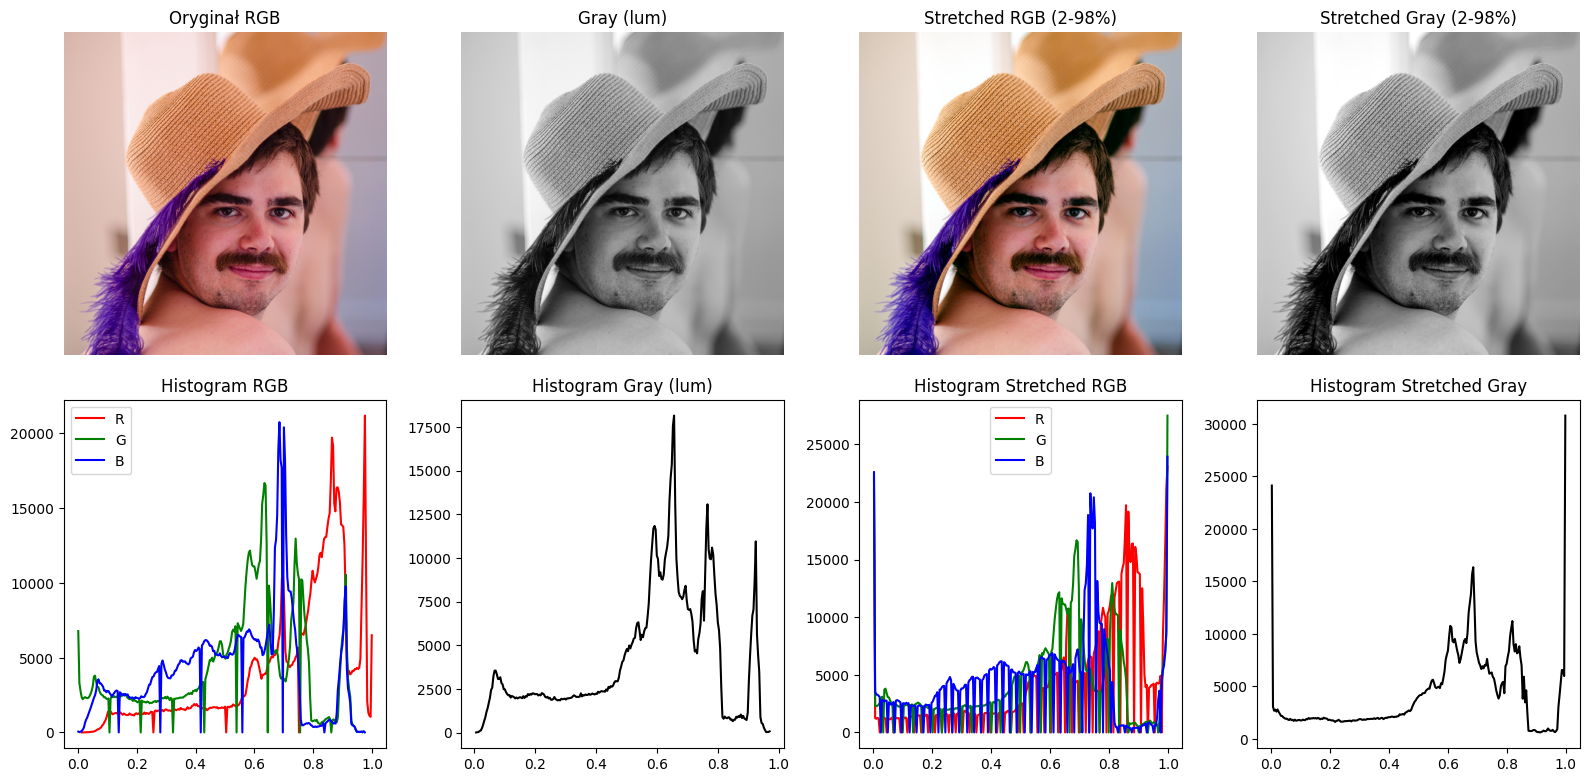

In [28]:
def histogram_explorer(img, p_low=2, p_high=98, gray_method='lum'):
    """
    Eksplorator histogramów: wyświetla oryginał, stretched oraz histogramy.

    Parametry:
    - img: obraz RGB lub grayscale
    - p_low, p_high: percentyle dla stretching (domyślnie 2-98%)
    - gray_method: sposób konwersji do gray: 'lum' (luminancja), 'avg' (średnia), 'r', 'g', 'b'
    """
    # Ujednolicenie do RGB jeśli grayscale
    if img.ndim == 2:
        img_rgb = np.stack([img, img, img], axis=-1)
    else:
        img_rgb = img[..., :3]

    # Konwersja do float [0,1]
    img_rgb = img_rgb.astype(np.float64) / 255.0

    # Konwersja do gray wg metody
    if gray_method == 'lum':
        gray = color.rgb2gray(img_rgb)
    elif gray_method == 'avg':
        gray = np.mean(img_rgb, axis=-1)
    elif gray_method == 'r':
        gray = img_rgb[..., 0]
    elif gray_method == 'g':
        gray = img_rgb[..., 1]
    elif gray_method == 'b':
        gray = img_rgb[..., 2]
    else:
        gray = color.rgb2gray(img_rgb)

    # Histogramy przed
    hist_gray, bins_gray = exposure.histogram(gray, nbins=256)
    r = img_rgb[..., 0]
    g = img_rgb[..., 1]
    b = img_rgb[..., 2]
    hist_r, bins_r = exposure.histogram(r, nbins=256)
    hist_g, bins_g = exposure.histogram(g, nbins=256)
    hist_b, bins_b = exposure.histogram(b, nbins=256)

    # Stretching
    stretched_gray = exposure.rescale_intensity(gray, in_range=(np.percentile(gray, p_low), np.percentile(gray, p_high)), out_range=(0, 1))
    # For RGB, rescale each channel separately
    stretched_rgb = np.zeros_like(img_rgb)
    for i in range(3):
        stretched_rgb[..., i] = exposure.rescale_intensity(img_rgb[..., i], in_range=(np.percentile(img_rgb[..., i], p_low), np.percentile(img_rgb[..., i], p_high)), out_range=(0, 1))

    # Histogramy po
    hist_stretched_gray, bins_stretched_gray = exposure.histogram(stretched_gray, nbins=256)
    hist_stretched_r, bins_stretched_r = exposure.histogram(stretched_rgb[..., 0], nbins=256)
    hist_stretched_g, bins_stretched_g = exposure.histogram(stretched_rgb[..., 1], nbins=256)
    hist_stretched_b, bins_stretched_b = exposure.histogram(stretched_rgb[..., 2], nbins=256)

    # Wyświetlanie
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    # Pierwszy wiersz: obrazy
    axes[0,0].imshow(img_rgb)
    axes[0,0].set_title('Oryginał RGB')
    axes[0,0].axis('off')

    axes[0,1].imshow(gray, cmap='gray')
    axes[0,1].set_title(f'Gray ({gray_method})')
    axes[0,1].axis('off')

    axes[0,2].imshow(stretched_rgb)
    axes[0,2].set_title(f'Stretched RGB ({p_low}-{p_high}%)')
    axes[0,2].axis('off')

    axes[0,3].imshow(stretched_gray, cmap='gray')
    axes[0,3].set_title(f'Stretched Gray ({p_low}-{p_high}%)')
    axes[0,3].axis('off')

    # Drugi wiersz: histogramy
    axes[1,0].plot(bins_r, hist_r, 'r', label='R')
    axes[1,0].plot(bins_g, hist_g, 'g', label='G')
    axes[1,0].plot(bins_b, hist_b, 'b', label='B')
    axes[1,0].set_title('Histogram RGB')
    axes[1,0].legend()

    axes[1,1].plot(bins_gray, hist_gray, 'k')
    axes[1,1].set_title(f'Histogram Gray ({gray_method})')

    axes[1,2].plot(bins_stretched_r, hist_stretched_r, 'r', label='R')
    axes[1,2].plot(bins_stretched_g, hist_stretched_g, 'g', label='G')
    axes[1,2].plot(bins_stretched_b, hist_stretched_b, 'b', label='B')
    axes[1,2].set_title(f'Histogram Stretched RGB')
    axes[1,2].legend()

    axes[1,3].plot(bins_stretched_gray, hist_stretched_gray, 'k')
    axes[1,3].set_title(f'Histogram Stretched Gray')

    plt.tight_layout()
    plt.show()

# Przykład użycia
img = io.imread('lena.png')
histogram_explorer(img, p_low=2, p_high=98, gray_method='lum')

### Wynik Zadanie 1
Przy 2-98% percentylach, histogram rozciąga się bardziej, zwiększając kontrast bez utraty ekstremalnych wartości, co może prowadzić do lepszego wykorzystania zakresu jasności. W porównaniu do 1-99%, gdzie uwzględnia się więcej skrajnych wartości, kontrast jest mniej agresywny, ale obraz może wydawać się mniej żywy, z mniejszym ryzykiem artefaktów w jasnych/ciemnnych obszarach.

## Zadanie 2. Normalizacja vs wyrównanie histogramu vs gamma

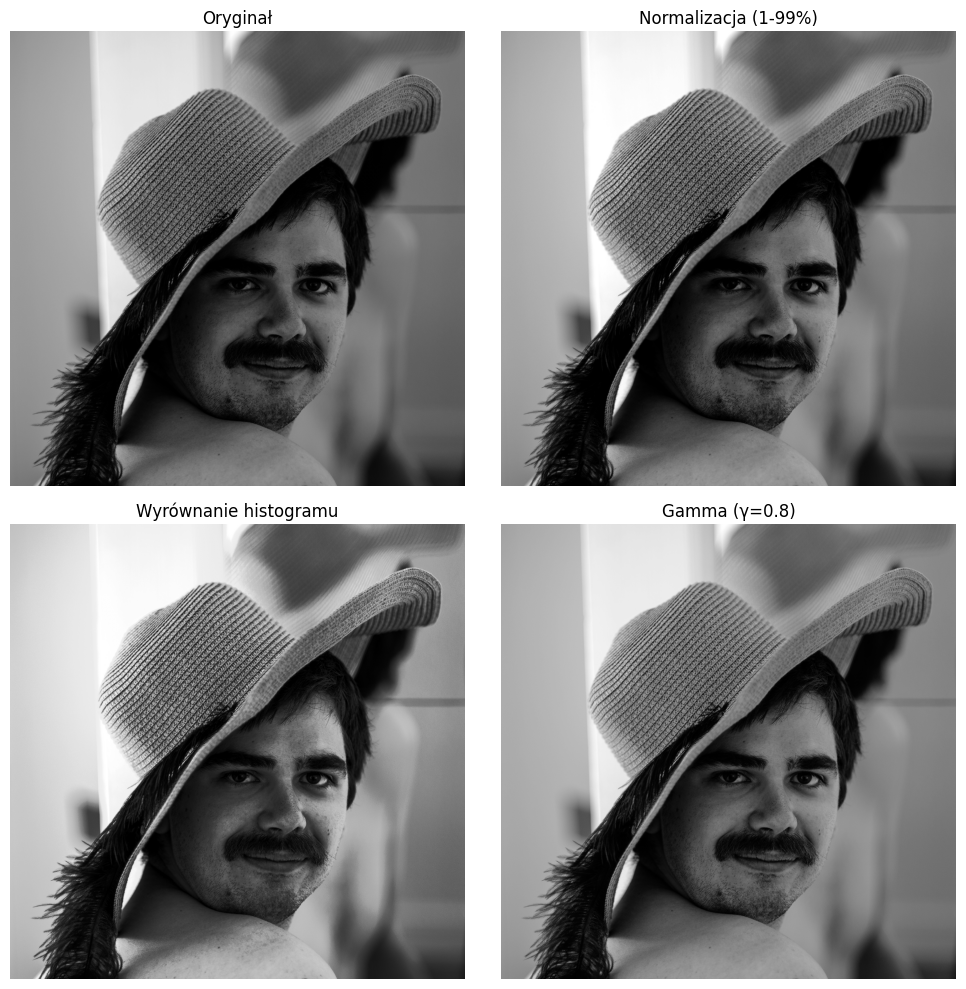

In [8]:
def compare_contrast_methods(img, norm_percentiles=(1,99), gamma_values=[0.6, 0.8, 1.2]):
    """
    Porównuje normalizację, wyrównanie histogramu i korekcę gamma.

    Zwraca figurę 2x2 i słownik parametrów.
    """
    # Konwersja do gray jeśli RGB
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img

    # Normalizacja
    norm = exposure.rescale_intensity(gray, in_range=(np.percentile(gray, norm_percentiles[0]), np.percentile(gray, norm_percentiles[1])), out_range=(0,1))

    # Wyrównanie histogramu
    eq = exposure.equalize_hist(gray)

    # Gamma - wybierz jedno, np. 0.8
    gamma = exposure.adjust_gamma(gray, gamma=0.8)

    # Siatka 2x2
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0,0].imshow(gray, cmap='gray')
    axes[0,0].set_title('Oryginał')
    axes[0,0].axis('off')

    axes[0,1].imshow(norm, cmap='gray')
    axes[0,1].set_title(f'Normalizacja ({norm_percentiles[0]}-{norm_percentiles[1]}%)')
    axes[0,1].axis('off')

    axes[1,0].imshow(eq, cmap='gray')
    axes[1,0].set_title('Wyrównanie histogramu')
    axes[1,0].axis('off')

    axes[1,1].imshow(gamma, cmap='gray')
    axes[1,1].set_title('Gamma (γ=0.8)')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    params = {
        'normalization': f'percentiles {norm_percentiles}',
        'equalization': 'global equalize_hist',
        'gamma': 'γ=0.8'
    }

    return fig, params

# Przykład z ciemnym obrazem - użyjemy lena.png, ale symulujemy ciemny
img = io.imread('lena.png')
gray = color.rgb2gray(img)
dark_img = exposure.adjust_gamma(gray, gamma=2.0)  # Przyciemnij
fig, params = compare_contrast_methods(dark_img)

### Komentarz Zadanie 2
Normalizacja liniowo rozciąga zakres jasności, zachowując proporcje, co jest dobre dla obrazów z nierównym oświetleniem, ale może nie poprawić kontrastu w środkowym zakresie. Wyrównanie histogramu czyni rozkład bardziej równomiernym, zwiększając kontrast lokalny, ale może powodować przepalenia w jasnych obszarach i banding. Korekcja gamma (γ<1) rozjaśnia cienie, co pomaga w ciemnych obrazach, ale może zmniejszyć kontrast w światłach. Wybór metody zależy od potrzeb: normalizacja dla liniowości, wyrównanie dla globalnego kontrastu, gamma dla adaptacji do percepcji ludzkiego oka.

## Zadanie 3. Lokalny kontrast (CLAHE)

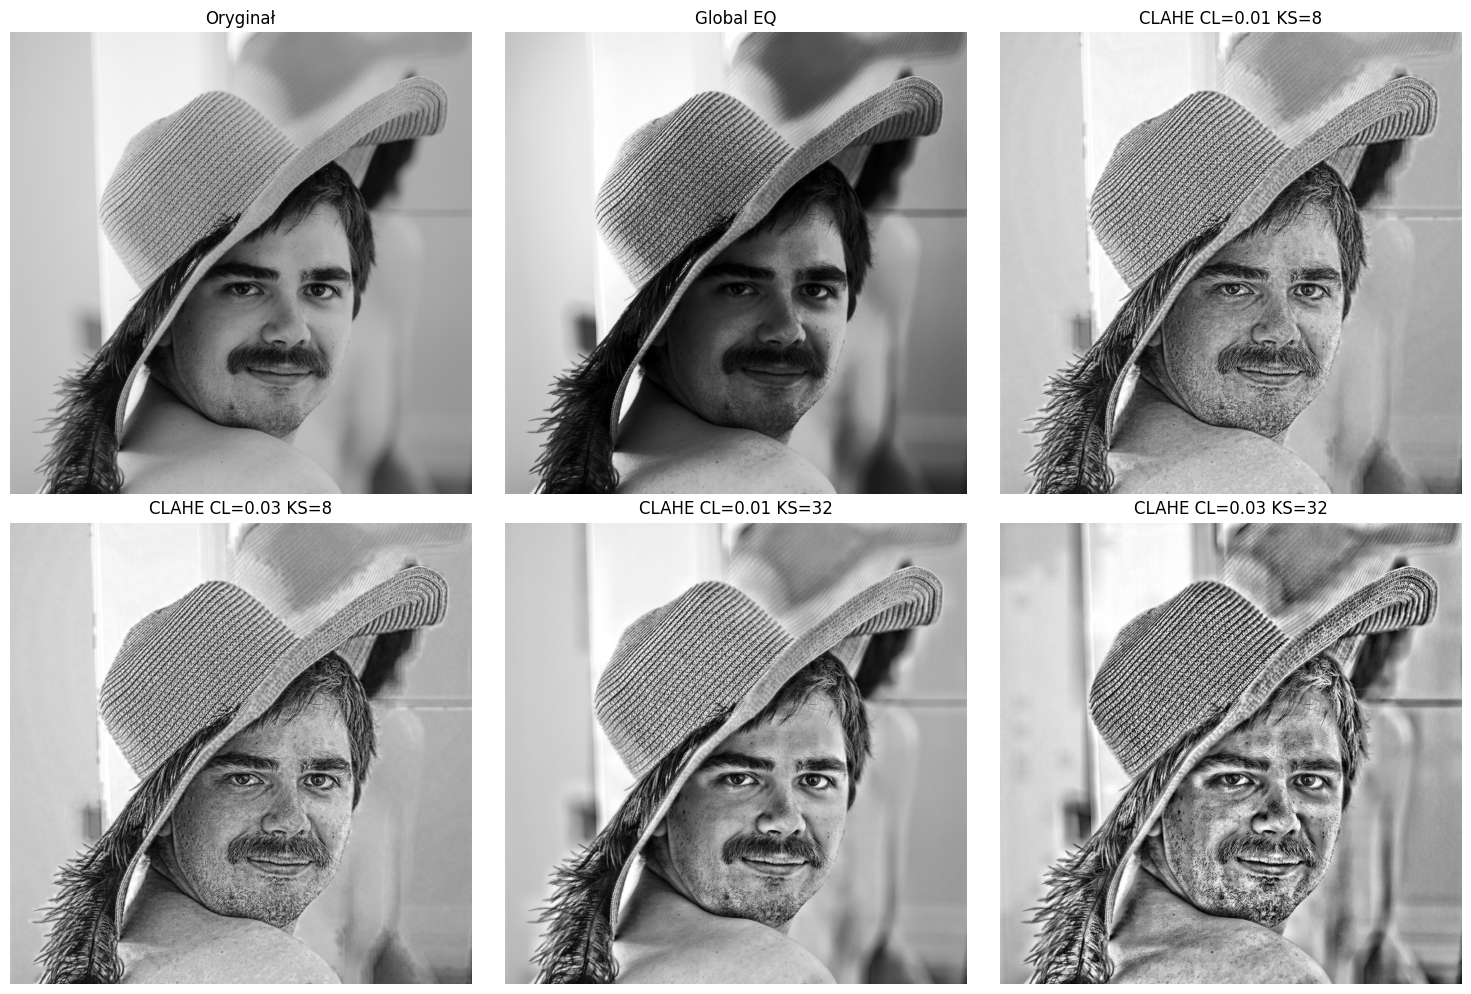

In [9]:
def clahe_demo(img, clip_limit=0.01, kernel_size=8):
    """
    Zastosuj CLAHE do obrazu.
    """
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img
    clahe = exposure.equalize_adapthist(gray, clip_limit=clip_limit, nbins=256, kernel_size=kernel_size)
    return clahe

# Porównanie
img = io.imread('lena.png')
gray = color.rgb2gray(img)

# Globalne wyrównanie
global_eq = exposure.equalize_hist(gray)

# CLAHE warianty
clahe1 = clahe_demo(gray, clip_limit=0.01, kernel_size=8)
clahe2 = clahe_demo(gray, clip_limit=0.03, kernel_size=8)
clahe3 = clahe_demo(gray, clip_limit=0.01, kernel_size=32)
clahe4 = clahe_demo(gray, clip_limit=0.03, kernel_size=32)

# Mozaika
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
images = [gray, global_eq, clahe1, clahe2, clahe3, clahe4]
titles = ['Oryginał', 'Global EQ', 'CLAHE CL=0.01 KS=8', 'CLAHE CL=0.03 KS=8', 'CLAHE CL=0.01 KS=32', 'CLAHE CL=0.03 KS=32']

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### Notatka Zadanie 3
Niższy clip_limit (np. 0.01) ogranicza wzmocnienie kontrastu, redukując szum i halo, ale może nie poprawić detali w cieniach. Wyższy clip_limit (0.03) zwiększa wzmocnienie, co uwidacznia szczegóły, ale może powodować plastikowy wygląd i przepalenia. Mały kernel_size (8x8) daje lokalny kontrast, dobry dla drobnych detali, ale może wprowadzić szum. Duży kernel_size (32x32) działa globalniej, chroniąc światła, ale mniej efektywny dla lokalnych zmian. CLAHE lepiej niż globalne wyrównanie chroni światła i unika banding, idealny dla obrazów z nierównym oświetleniem.

## Zadanie 4. Rozkład informacji w przestrzeniach barw (HSV, LAB, YUV)

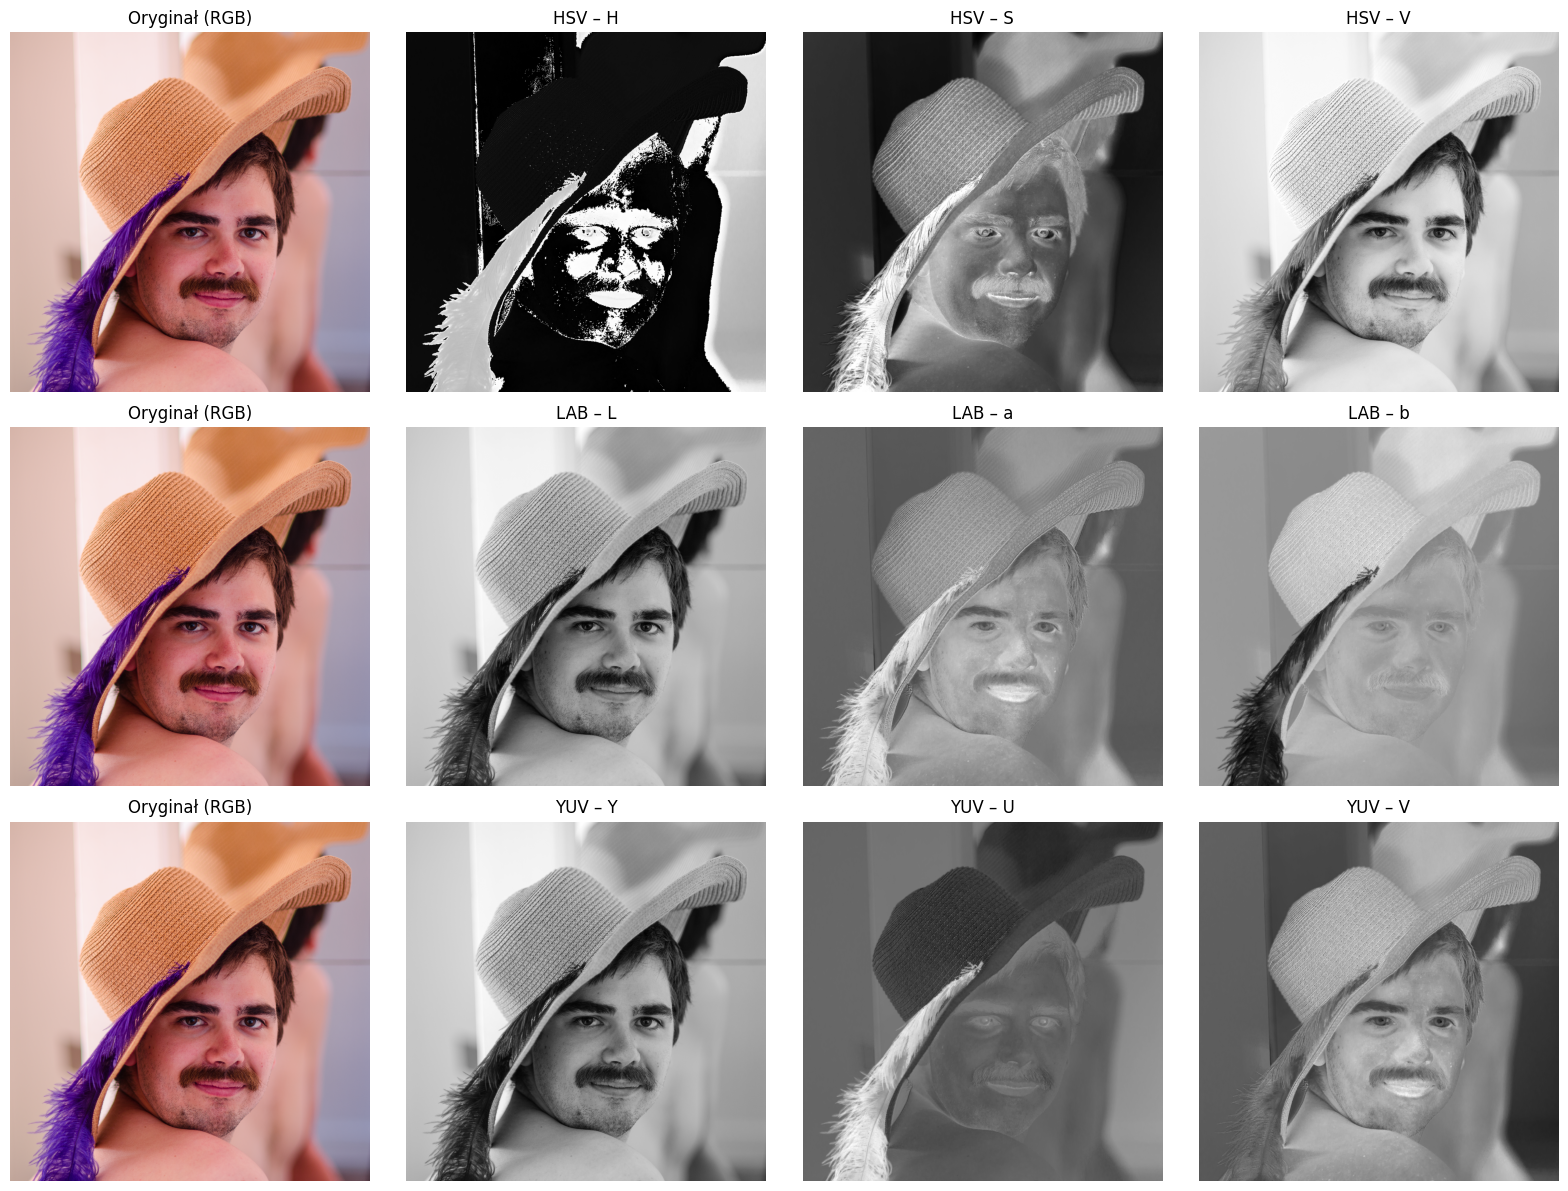

In [10]:
# Wczytanie obrazu
img_rgb = io.imread('lena.png')

# Konwersje
img_hsv = color.rgb2hsv(img_rgb)
img_lab = color.rgb2lab(img_rgb)
img_yuv = color.rgb2yuv(img_rgb)

# Funkcja do wyświetlania kanałów
def show_color_spaces(img_rgb, img_hsv, img_lab, img_yuv):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    spaces = [('HSV', img_hsv, ['H', 'S', 'V']), ('LAB', img_lab, ['L', 'a', 'b']), ('YUV', img_yuv, ['Y', 'U', 'V'])]

    for row, (name, img, channels) in enumerate(spaces):
        axes[row, 0].imshow(img_rgb)
        axes[row, 0].set_title(f'Oryginał (RGB)')
        axes[row, 0].axis('off')

        for col, ch in enumerate(channels, 1):
            channel = img[..., col-1]
            # Przeskaluj jeśli ujemne (LAB a,b)
            if name == 'LAB' and col > 1:
                channel = (channel - channel.min()) / (channel.max() - channel.min())
            axes[row, col].imshow(channel, cmap='gray')
            axes[row, col].set_title(f'{name} – {ch}')
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

show_color_spaces(img_rgb, img_hsv, img_lab, img_yuv)

### Notatka Zadanie 4
Kanały luminancji (L w LAB, Y w YUV, V w HSV) najlepiej niosą informację o jasności, krawędziach i fakturze, co czyni je idealnymi do detekcji obiektów i analizy strukturalnej. Kanały chromatyczne różnią się: H w HSV opisuje odcień intuicyjnie (kolory), S nasycenie (żywość koloru), podczas gdy a/b w LAB i U/V w YUV kodują różnice kolorów względem luminancji. LAB lepiej dopasowuje percepcję ludzką, YUV jest efektywny w kompresji, a HSV ułatwia segmentację kolorów. Granice obiektów są wyraźniejsze w kanałach jasności (L/Y/V), co pomaga w przetwarzaniu niezależnym od koloru.